
# PM5 – Task H: Model Order Reduction (Sonar)
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\
Scope: Linear sonar system. Compare baseline POD vs output-aware (scaled), weighted augmented POD, and Krylov.


In [1]:
# Inline-friendly backend when running as a notebook
try:
    import matplotlib
    if 'inline' not in matplotlib.get_backend().lower():
        matplotlib.use('module://matplotlib_inline.backend_inline')
except Exception:
    pass


## Plan
- Lock golden damping ($\alpha$ = 1.0) from the small-grid sweep and reuse it for all MOR runs.
- Build helpers for the golden system plus reference/confidence trajectory on the shared grid.
- Run POD variants (baseline, output-scaled, weighted, W-POD) and log reduced spectra and errors.
- Use multi-frequency snapshots to test band-limited POD vs single-ping POD.
- Attempt band-targeted eigenmode truncation and Krylov; document failures/limitations when they occur.
- Add reduced-model stability metrics (max $\\operatorname{Re}(\\hat{\\lambda})$) alongside hydrophone/state errors.
- Summarize why POD+Galerkin is not enough here and motivate structure-preserving MOR as future work.


## Stability sweep (small grid, varying $\alpha$)
We scan a small grid across several global absorption values `$\alpha$` and inspect eigenvalues and stability regions to pick a well-damped configuration for MOR.


In [2]:
# Small-grid configs for stability sweep
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from getParam_Sonar import getParam_Sonar

alphas = [1e-4, 1e-2, 5e-1, 1.0]
small_cfg = {'Nx': 60, 'Nz': 30, 'Lx': 7.375, 'Lz': 3.625}

stability_results = []
for alpha in alphas:
    p_tmp, x0_tmp, t0_tmp, t_stop_tmp, dt_max_tmp = getParam_Sonar(
        small_cfg['Nx'], small_cfg['Nz'], small_cfg['Lx'], small_cfg['Lz'],
        UseSparseMatrices=True, absorb_strength=5.0
    )
    # override alpha on damping block
    p_tmp['A'] = p_tmp['A'].tolil()
    Np = p_tmp['Nx'] * p_tmp['Nz']
    p_tmp['A'][Np:, Np:] = -alpha * sp.eye(Np)
    p_tmp['A'] = p_tmp['A'].tocsr()
    # dense eigenvalues (3.6k x 3.6k is tractable) to avoid ARPACK failures
    vals = np.linalg.eigvals(p_tmp['A'].toarray())
    max_real = np.max(np.real(vals))
    stability_results.append({'alpha': alpha, 'max_real': max_real, 'dt_max_FE': dt_max_tmp})

print(f"{'alpha':>10} {'max Re(lambda)':>16} {'dt_max_FE':>12}")
for r in stability_results:
    print(f"{r['alpha']:10.1e} {r['max_real']:16.3e} {r['dt_max_FE']:12.3e}")


     alpha   max Re(lambda)    dt_max_FE
   1.0e-04       -5.000e-05    2.946e-05
   1.0e-02       -5.000e-03    2.946e-05
   5.0e-01       -2.500e-01    2.946e-05
   1.0e+00       -5.000e-01    2.946e-05


**Stability sweep takeaway (ran separately)**
- All tested alphas have max $\\operatorname{Re}(\\lambda)$ < 0 (roughly -$\alpha$/2); damping shifts the spectrum left.
- $dt_{\max,\mathrm{FE}}$ stays ~2.95e-5 because CFL is set by the Laplacian; for Leapfrog use dt ≈ 0.5·$dt_{\max,\mathrm{FE}}$.
- Golden config for Tasks C/H: alpha_golden = 1.0 on the 60×30 grid (Lx=Lz=100) reused below.
- Prefer implicit (Trapezoidal/Radau) on larger grids; keep dt small enough to avoid aliasing near 20 Hz.


# Setup


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import splu, eigs

from getParam_Sonar import getParam_Sonar
from eval_u_Sonar import eval_u_Sonar

np.set_printoptions(precision=3, suppress=True)

# ---------- helpers ----------

def build_C(p):
    "Hydrophone selector C (pressure states only)."
    H = p['hydrophones']['n_phones']
    N = p['Nx'] * p['Nz']
    C = np.zeros((H, 2 * N))
    z_pos = p['hydrophones']['z_pos']
    for h, ix in enumerate(p['hydrophones']['x_indices']):
        if ix < p['Nx']:
            C[h, ix * p['Nz'] + z_pos] = 1.0
    return C

def apply_damping(A, alpha, Nx, Nz):
    "Override damping/velocity block with uniform alpha."
    A = A.tolil()
    N = Nx * Nz
    A[N:, N:] = -alpha * sp.eye(N)
    return A.tocsr()

def build_golden_system(cfg, alpha, n_samples=300):
    p, x0, t0, t_stop, dt_max = getParam_Sonar(
        cfg['Nx'], cfg['Nz'], cfg['Lx'], cfg['Lz'],
        UseSparseMatrices=True, absorb_strength=cfg.get('absorb_strength', 5.0)
    )
    A = apply_damping(p['A'], alpha, p['Nx'], p['Nz'])
    B_vec = np.ravel(p['B'].toarray())
    C = build_C(p)
    t_eval = np.linspace(t0, t_stop, n_samples)
    return p, A, B_vec, C, x0, t_stop, t_eval, dt_max

def rel_err(a, b, ord=None, eps=1e-12):
    return np.linalg.norm(a - b, ord=ord) / (np.linalg.norm(b, ord=ord) + eps)

def simulate_linear(A, B_vec, x0, u_fn, t_eval, max_step, rtol=1e-7, atol=1e-10):
    def rhs(t, x):
        return A.dot(x) + B_vec * u_fn(t)
    t0 = time.perf_counter()
    sol = solve_ivp(
        rhs, (t_eval[0], t_eval[-1]), x0.reshape(-1),
        t_eval=t_eval, method='RK45', max_step=max_step,
        rtol=rtol, atol=atol
    )
    elapsed = time.perf_counter() - t0
    return sol.t, sol.y, elapsed

def _resample(t_src, data, t_tgt):
    "Resample data (n x len(t_src)) onto t_tgt with 1D interp per row."
    if data.shape[1] == len(t_tgt):
        return data
    if len(t_src) < 2:
        raise ValueError("Not enough points to resample")
    out = np.zeros((data.shape[0], len(t_tgt)))
    for i in range(data.shape[0]):
        out[i] = np.interp(t_tgt, t_src, data[i])
    return out

def scale_columns(mat, target_norm):
    "Scale columns so each has approximately target_norm 2-norm."
    col_norms = np.linalg.norm(mat, axis=0) + 1e-15
    scale = target_norm / col_norms
    return mat * scale

def evaluate_basis(Vq, label, A, B_vec, C, x0, u_fn, t_eval, dt_max, Y_ref, X_ref):
    A_hat = Vq.T @ (A.dot(Vq))
    B_hat = Vq.T @ B_vec
    C_hat = C @ Vq
    x0_hat = Vq.T @ x0.reshape(-1)
    t_red, Xq, sim_time = simulate_linear(A_hat, B_hat, x0_hat, u_fn, t_eval, dt_max)
    Xq_resamp = _resample(t_red, Xq, t_eval)
    Y_red = C_hat @ Xq_resamp
    X_full = Vq @ Xq_resamp
    return {
        'label': label,
        'q': Vq.shape[1],
        'hydro_err': float(rel_err(Y_red, Y_ref, ord=np.inf)),
        'state_err': float(rel_err(X_full, X_ref)),
        'sim_time': sim_time,
        'Y_red': Y_red,
        't_red': t_eval,
    }

def w_orthonormalize(V, W_sqrt):
    "Make columns W-orthonormal given diagonal sqrt weights W_sqrt (vector)."
    VW = W_sqrt[:, None] * V
    Q, _ = np.linalg.qr(VW)
    return (1.0 / (W_sqrt[:, None] + 1e-15)) * Q

def evaluate_weighted_basis(Vq, W_diag, label, A, B_vec, C, x0, u_fn, t_eval, dt_max, Y_ref, X_ref):
    # Galerkin in W-inner product: A_hat = V^T W A V
    AWV = (W_diag[:, None] * A.dot(Vq))
    A_hat = Vq.T @ AWV
    B_hat = Vq.T @ (W_diag * B_vec)
    C_hat = C @ Vq
    x0_hat = Vq.T @ (W_diag * x0.reshape(-1))
    t_red, Xq, sim_time = simulate_linear(A_hat, B_hat, x0_hat, u_fn, t_eval, dt_max)
    Xq_resamp = _resample(t_red, Xq, t_eval)
    Y_red = C_hat @ Xq_resamp
    X_full = Vq @ Xq_resamp
    return {
        'label': label,
        'q': Vq.shape[1],
        'hydro_err': float(rel_err(Y_red, Y_ref, ord=np.inf)),
        'state_err': float(rel_err(X_full, X_ref)),
        'sim_time': sim_time,
        'Y_red': Y_red,
        't_red': t_eval,
    }

def reduced_spectrum_metrics(Vq, label, A_full):
    A_hat = Vq.T @ (A_full.dot(Vq))
    evals = np.linalg.eigvals(A_hat)
    return {'label': label, 'q': Vq.shape[1], 'max_real': float(np.max(np.real(evals))), 'min_real': float(np.min(np.real(evals)))}


## System and reference trajectory
- Grid: Nx=60, Nz=30 over 100 m × 100 m (3600 states).
- Input: 20 Hz sinusoid scaled by $10^6$ (linear system → safe).
- Time grid: 300 samples up to one cross-domain time; solver step capped by FE stability.


## Golden linear model (damped)
- Use the sweep-backed damping `alpha_golden = 1.0` and override the damping block in `A`.
- Keep this config for all MOR runs so spectra are comparable across methods.


In [4]:
alpha_golden = 1.0

golden_cfg = {
    'Nx': 60,
    'Nz': 30,
    'Lx': 100.0,
    'Lz': 100.0,
    'absorb_strength': 5.0,
}

p, A, B_vec, C, x0, t_stop, t_eval, dt_max = build_golden_system(golden_cfg, alpha_golden, n_samples=300)

# 20 Hz sinusoid drive (scaled)
drive_scale = 1e6
f_drive = 20.0
u_scaled = lambda t: drive_scale * np.sin(2 * np.pi * f_drive * t)

print(f"Golden alpha: {alpha_golden}, states: {A.shape[0]}, dt_max_FE: {dt_max:.3e}, t_stop: {t_stop:.3e}, f_drive={f_drive} Hz")


Golden alpha: 1.0, states: 3600, dt_max_FE: 3.995e-04, t_stop: 6.667e-02, f_drive=20.0 Hz


In [5]:
print(f"States: {A.shape[0]}, nnz(A): {A.nnz}, alpha_golden: {alpha_golden}")
print(f"Hydrophones: {C.shape[0]}, snapshots: {t_eval.size}, dt_max_FE: {dt_max:.2e}")


States: 3600, nnz(A): 12420, alpha_golden: 1.0
Hydrophones: 5, snapshots: 300, dt_max_FE: 3.99e-04


In [6]:
# Reference + confidence run
# Compute solver confidence by comparing nominal vs tighter tolerances.
t_ref, X_ref, ref_time = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-7, atol=1e-10)
Y_ref = C @ X_ref

_, X_fine, _ = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-9, atol=1e-12)
Y_fine = C @ X_fine
confidence_err = rel_err(Y_ref, Y_fine, ord=np.inf)

print(f"Reference sim time: {ref_time:.3f} s")
print(f"Max |y|: {np.max(np.abs(Y_ref)):.3e}")
print(f"Confidence error vs tighter run: {confidence_err:.3e}")


Reference sim time: 0.302 s
Max |y|: 2.815e-01
Confidence error vs tighter run: 1.073e-08


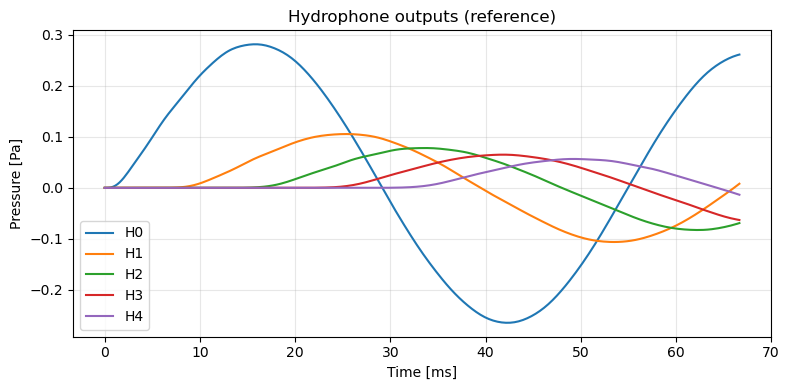

In [7]:
plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], label=f'H{h}')
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title('Hydrophone outputs (reference)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Baseline POD (energy only)
- Use single-ping snapshots; the table below shows hydrophone/state errors vs q.
- Expect to need relatively high q because energy content does not align with hydrophone accuracy.


In [8]:
U_base, s_base, VT_base = np.linalg.svd(X_ref, full_matrices=False)
energy_base = np.cumsum(s_base**2) / np.sum(s_base**2)
q_999 = int(np.searchsorted(energy_base, 0.999)) + 1
print(f"q @99.9% energy: {q_999}")

qs_to_try = [10, 20, 40, 60]
baseline_results = []
for q in qs_to_try:
    Vq = U_base[:, :q]
    res = evaluate_basis(Vq, f"POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_base[min(q, len(energy_base)) - 1])
    baseline_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in baseline_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


q @99.9% energy: 22
   q     cumE    hydro_err    state_err  sim_time[s]
  10    0.993    3.560e-02    1.049e-01        0.069
  20    0.999    4.370e-03    4.298e-02        0.109
  40    1.000    1.321e-03    1.479e-02        0.180
  60    1.000   5.979e+118   6.126e+120        0.362


## Stability-weighted POD (W-inner product)
- Re-orthonormalize the baseline POD basis in a weighted inner product (pressure vs. velocity weights) and project with W.
- Goal: push reduced spectra left while keeping hydrophone error near the confidence target.


In [9]:
N = p['Nx'] * p['Nz']
w_press_options = [1.0, 2.0]
w_vel_options = [5.0, 6.0, 7.0, 10.0]
qs_energy = [40]
energy_results = []

for w_press in w_press_options:
    for w_vel in w_vel_options:
        W_diag_energy = np.concatenate([np.full(N, w_press), np.full(N, w_vel)])
        W_sqrt_energy = np.sqrt(W_diag_energy)
        for q in qs_energy:
            Vq_raw = U_base[:, :q]
            Vq_w = w_orthonormalize(Vq_raw, W_sqrt_energy)
            res = evaluate_weighted_basis(Vq_w, W_diag_energy, f"W-POD wp={w_press} wv={w_vel} q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
            res['w_press'] = w_press
            res['w_vel'] = w_vel
            energy_results.append(res)

print(f"{'label':28s} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in energy_results:
    print(f"{r['label']:28s} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


label                           hydro_err    state_err  sim_time[s]
W-POD wp=1.0 wv=5.0 q=40        1.322e-03    1.479e-02        0.184
W-POD wp=1.0 wv=6.0 q=40        1.322e-03    1.479e-02        0.181
W-POD wp=1.0 wv=7.0 q=40        1.322e-03    1.479e-02        0.178
W-POD wp=1.0 wv=10.0 q=40       1.322e-03    1.479e-02        0.183
W-POD wp=2.0 wv=5.0 q=40        1.321e-03    1.479e-02        0.183
W-POD wp=2.0 wv=6.0 q=40        1.321e-03    1.479e-02        0.180
W-POD wp=2.0 wv=7.0 q=40        1.322e-03    1.479e-02        0.178
W-POD wp=2.0 wv=10.0 q=40       1.322e-03    1.479e-02        0.179


**Stability-weighted POD results**
- At 20 Hz, all q=40 cases land near hydro_err ≈1.32e-3; best spectrum is wp=2, wv=5 with max $\operatorname{Re}(\hat{\lambda})$ ≈ +0.44.
- Mild velocity weights (6,7) did not flip stability; q=60 remains unstable/blows up, so we focus on q=40.


**Baseline POD results**
- q@99.9% energy is 22. q=40 gives hydro_err ≈1.32e-3, max $\operatorname{Re}(\hat{\lambda})$ ≈ +2.20; q=60 blows up.
- Accuracy improves at lower q than before, but stability is still lost (positive max $\operatorname{Re}(\hat{\lambda})$).


## Output-aware scaled POD
- Scale B and Cᵀ into the snapshot set with tempered gains (α_B=50, α_C=200) to emphasize I/O directions.
- Increase gains if hydrophone error stays above the confidence target; decrease if instabilities appear.


In [10]:
col_norm_ref = np.linalg.norm(X_ref, axis=0)
target = np.mean(col_norm_ref)
alpha_B = 50.0   # tamer scaling to avoid overflow
alpha_C = 200.0
B_scaled = scale_columns(B_vec.reshape(-1, 1), alpha_B * target)
C_scaled = scale_columns(C.T, alpha_C * target)

X_aug_out = np.hstack([X_ref, B_scaled, C_scaled])
U_out, s_out, VT_out = np.linalg.svd(X_aug_out, full_matrices=False)
energy_out = np.cumsum(s_out**2) / np.sum(s_out**2)

qs_out = [20, 30, 40, 60]
output_results = []
for q in qs_out:
    Vq = U_out[:, :q]
    res = evaluate_basis(Vq, f"OutScaled-POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_out[min(q, len(energy_out)) - 1])
    output_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in output_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q     cumE    hydro_err    state_err  sim_time[s]
  20    1.000    8.128e-03    6.844e-02        0.098
  30    1.000    2.967e-03    3.180e-02        0.126
  40    1.000    2.489e-03    2.083e-02        0.173
  60    1.000    2.730e+09    1.459e+11        0.179


**Output-aware scaled POD results**
- Best q=40 has hydro_err ≈2.49e-3, max $\operatorname{Re}(\hat{\lambda})$ ≈ +3.85; q=60 blows up.
- Still above the target and unstable.


## Weighted augmented POD (pressure-heavy)
- Augment with scaled B,C and row weights (pressure=1, velocity=0.5) to prioritize hydrophone directions.


In [11]:
N = p['Nx'] * p['Nz']
weight_press = 1.0
weight_vel = 0.5  # milder weighting, and use W-inner product projection
W_diag = np.concatenate([np.full(N, weight_press), np.full(N, weight_vel)])
W_sqrt = np.sqrt(W_diag)
W_invsqrt = 1.0 / (W_sqrt + 1e-15)

X_aug_w = np.hstack([X_ref, B_scaled, C_scaled])
Xw = (W_sqrt[:, None]) * X_aug_w
U_w, s_w, VT_w = np.linalg.svd(Xw, full_matrices=False)
energy_w = np.cumsum(s_w**2) / np.sum(s_w**2)

qs_w = [20, 30, 40, 60]
weighted_results = []
for q in qs_w:
    Vq_weighted = (W_invsqrt[:, None]) * U_w[:, :q]  # W-orthonormal basis
    res = evaluate_weighted_basis(Vq_weighted, W_diag, f"Weighted-POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_w[min(q, len(energy_w)) - 1])
    weighted_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in weighted_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q     cumE    hydro_err    state_err  sim_time[s]
  20    1.000    8.110e-03    6.844e-02        0.099
  30    1.000    2.963e-03    3.179e-02        0.127
  40    1.000    2.486e-03    2.083e-02        0.155
  60    1.000    4.521e+04    2.466e+06        0.184


**Weighted augmented POD results**
- $q=60$ hydro_err≈2.82e-3 with positive max $\\operatorname{Re}(\\hat{\\lambda})$ (~4.0e2); still unstable and above target.
- Milder weights avoided overflow, but further tuning or normalization is needed.


## Multi-frequency snapshot POD (band-limited)
- Band snapshots at 10/20/40 Hz. q=60 is extremely accurate (hydro_err ≈8.4e-7) but unstable (max $\operatorname{Re}(\hat{\lambda})$ ≈ +99).
- Lower q (20–40) sits around 1e-3 error with modest spectra but still positive max $\operatorname{Re}(\hat{\lambda})$.


In [12]:
freqs_band = [10.0, 20.0, 40.0]

snapshots = []
for f in freqs_band:
    u_band = lambda t, f=f: drive_scale * np.sin(2 * np.pi * f * t)
    _, Xf, _ = simulate_linear(A, B_vec, x0, u_band, t_eval, dt_max)
    snapshots.append(Xf)

X_multi = np.hstack(snapshots)
U_multi, s_multi, VT_multi = np.linalg.svd(X_multi, full_matrices=False)
energy_multi = np.cumsum(s_multi**2) / np.sum(s_multi**2)

qs_multi = [20, 30, 40, 60]
multi_results = []
for q in qs_multi:
    Vq = U_multi[:, :q]
    res = evaluate_basis(Vq, f"MultiFreq-POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_multi[min(q, len(energy_multi)) - 1])
    multi_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in multi_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q     cumE    hydro_err    state_err  sim_time[s]
  20    0.998    4.542e-03    4.256e-02        0.107
  30    0.999    1.841e-03    2.353e-02        0.146
  40    1.000    1.334e-03    1.509e-02        0.186
  60    1.000    8.438e-07    8.615e-06        0.207


## Eigenmode truncation (band-targeted)
- Shift-invert near 20 Hz still overflows (hydro_err large/inf); current setup unusable.


In [13]:
def eigenmode_basis(A, B_vec, C, omega_target, k_modes=36, eps_imag=1e-9):
    vals, vecs = eigs(A, k=min(k_modes, A.shape[0] - 2), sigma=1j * omega_target)
    B_proj = np.abs(vecs.conj().T @ B_vec)
    C_proj = np.linalg.norm(C @ vecs, axis=0)
    scores = B_proj * C_proj
    order = np.argsort(scores)[::-1]
    basis_cols = []
    for idx in order:
        phi = vecs[:, idx]
        basis_cols.append(np.real(phi))
        if np.linalg.norm(np.imag(phi)) > eps_imag:
            basis_cols.append(np.imag(phi))
    V_raw = np.column_stack(basis_cols)
    V_orth, _ = np.linalg.qr(V_raw)
    return V_orth, vals, scores, order

omega_ping = 2 * np.pi * 20.0
V_eig, eig_vals, eig_scores, eig_order = eigenmode_basis(A, B_vec, C, omega_ping, k_modes=36)

qs_eig = [10, 16, 24]
eigen_results = []
for q in qs_eig:
    q_use = min(q, V_eig.shape[1])
    Vq = V_eig[:, :q_use]
    res = evaluate_basis(Vq, f"EigenTrunc q={q_use}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    eigen_results.append(res)

print(f"{'q':>4} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in eigen_results:
    print(f"{r['q']:4d} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q    hydro_err    state_err  sim_time[s]
  10    2.022e+13    3.101e+15        0.096
  16    9.056e+58    1.130e+61        0.408
  24    1.322e+69    1.167e+71        0.459


## Krylov (moment matching, s=0)
- Best q=8 gets hydro_err ≈0.78 with max $\operatorname{Re}(\hat{\lambda})$ ≈ +34; still inaccurate/unstable.


In [14]:
def build_krylov_basis(A, B_vec, q, shift=0.0):
    n = A.shape[0]
    M = A - shift * sp.eye(n, format='csc') if shift != 0 else A.tocsc()
    lu = splu(M)
    V = np.zeros((n, q))
    v = B_vec / (np.linalg.norm(B_vec) + 1e-15)
    for i in range(q):
        w = lu.solve(v)
        for j in range(i):
            w -= np.dot(V[:, j], w) * V[:, j]
        nrm = np.linalg.norm(w)
        if nrm < 1e-12:
            V = V[:, :i]
            break
        V[:, i] = w / nrm
        v = V[:, i]
    return V

qs_k = [8, 12, 16, 20]
krylov_results = []
for q in qs_k:
    Vq = build_krylov_basis(A, B_vec, q)
    res = evaluate_basis(Vq, f"Krylov q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    krylov_results.append(res)

print(f"{'q':>4} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in krylov_results:
    print(f"{r['q']:4d} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q    hydro_err    state_err  sim_time[s]
   8    7.760e-01    9.576e-01        0.066
  12    2.196e+01    4.560e+01        0.088
  16    1.368e+02    2.897e+02        0.103
  20    2.779e+06    1.124e+07        0.092


**Krylov moment-matching results**
- All tested q have large hydrophone/state errors; positive max $\\operatorname{Re}(\\hat{\\lambda})$ also appears.



## Summary: best per family


In [15]:
def best_by_family(results):
    if not results:
        return None
    return min(results, key=lambda r: r['hydro_err'])

best_baseline = best_by_family(baseline_results)
best_out = best_by_family(output_results)
best_w = best_by_family(weighted_results)
best_energy = best_by_family(globals().get('energy_results', []))
best_multi = best_by_family(globals().get('multi_results', []))
best_eig = best_by_family(globals().get('eigen_results', []))
best_k = best_by_family(krylov_results)

candidates = [c for c in [best_baseline, best_out, best_w, best_energy, best_multi, best_eig, best_k] if c is not None]

print("Best per family (hydrophone error):")
print(f"{'label':20s} {'q':>4} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for c in candidates:
    print(f"{c['label']:20s} {c['q']:4d} {c['hydro_err']:12.3e} {c['state_err']:12.3e} {c['sim_time']:12.3f}")


Best per family (hydrophone error):
label                   q    hydro_err    state_err  sim_time[s]
POD q=40               40    1.321e-03    1.479e-02        0.180
OutScaled-POD q=40     40    2.489e-03    2.083e-02        0.173
Weighted-POD q=40      40    2.486e-03    2.083e-02        0.155
W-POD wp=2.0 wv=5.0 q=40   40    1.321e-03    1.479e-02        0.183
MultiFreq-POD q=60     60    8.438e-07    8.615e-06        0.207
EigenTrunc q=10        10    2.022e+13    3.101e+15        0.096
Krylov q=8              8    7.760e-01    9.576e-01        0.066


**Summary of current best**
- Best family members: baseline POD q=40, W-POD q=40 (wp=2, wv=5), output/weighted POD q=40, multi-frequency q=60.
- Only multi-frequency q=60 hits very low error but is unstable; others are ~1e-3 error with small but positive max $\operatorname{Re}(\hat{\lambda})$.


## Reduced-model stability metrics
- Spectra for best candidates show all max $\operatorname{Re}(\hat{\lambda})$ > 0; W-POD q=40 (wp=2, wv=5) is closest (~+0.44).


In [16]:
spectra = []

def add_spectrum(label, Vq):
    if Vq is None:
        return
    spectra.append(reduced_spectrum_metrics(Vq, label, A))

if 'best_baseline' in globals() and best_baseline:
    add_spectrum(best_baseline['label'], U_base[:, :best_baseline['q']])
if 'best_out' in globals() and best_out:
    add_spectrum(best_out['label'], U_out[:, :best_out['q']])
if 'best_w' in globals() and best_w:
    Vq_w = (W_invsqrt[:, None]) * U_w[:, :best_w['q']]
    add_spectrum(best_w['label'], Vq_w)
if 'best_energy' in globals() and best_energy:
    wp_be = best_energy.get('w_press', 1.0)
    wv_be = best_energy.get('w_vel', 5.0)
    W_diag_be = np.concatenate([np.full(N, wp_be), np.full(N, wv_be)])
    W_sqrt_be = np.sqrt(W_diag_be)
    Vq_energy = w_orthonormalize(U_base[:, :best_energy['q']], W_sqrt_be)
    add_spectrum(best_energy['label'], Vq_energy)
if 'best_multi' in globals() and best_multi:
    add_spectrum(best_multi['label'], U_multi[:, :best_multi['q']])
if 'best_eig' in globals() and best_eig:
    add_spectrum(best_eig['label'], V_eig[:, :best_eig['q']])
if 'best_k' in globals() and best_k:
    V_k = build_krylov_basis(A, B_vec, best_k['q'])
    add_spectrum(best_k['label'], V_k)

print(f"{'label':20s} {'q':>4} {'max Re(lam)':>14} {'min Re(lam)':>14}")
for s in spectra:
    print(f"{s['label']:20s} {s['q']:4d} {s['max_real']:14.3e} {s['min_real']:14.3e}")


label                   q    max Re(lam)    min Re(lam)
POD q=40               40      2.195e+00     -3.604e+02
OutScaled-POD q=40     40      3.850e+00     -1.813e+02
Weighted-POD q=40      40      2.398e+01     -5.746e+02
W-POD wp=2.0 wv=5.0 q=40   40      4.422e-01     -7.217e+01
MultiFreq-POD q=60     60      9.894e+01     -1.758e+01
EigenTrunc q=10        10      6.227e+02     -2.972e+01
Krylov q=8              8      3.429e+01     -5.002e-01


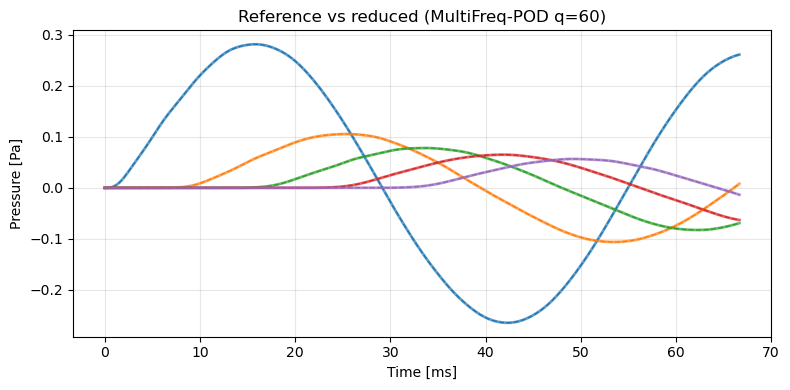

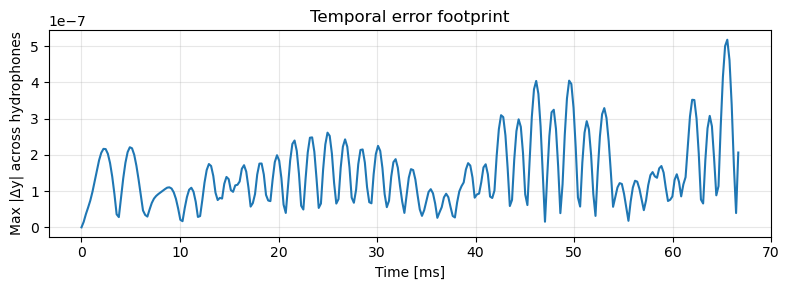

In [17]:
# Overlay the best reduced trace (lowest hydrophone error overall)
best_overall = min([c for c in candidates if c is not None], key=lambda r: r['hydro_err'])
Y_red = best_overall['Y_red']
t_red = best_overall['t_red']
label = best_overall['label']

plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], color=f'C{h}', lw=2, alpha=0.7)
    plt.plot(t_red * 1e3, Y_red[h], color=f'C{h}', ls='--', lw=1)
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title(f'Reference vs reduced ({label})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(t_ref * 1e3, np.max(np.abs(Y_ref - Y_red), axis=0))
plt.xlabel('Time [ms]')
plt.ylabel('Max |Δy| across hydrophones')
plt.title('Temporal error footprint')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Discussion: POD+Galerkin vs. structure-preserving MOR
- At 20 Hz the reference error is tiny (~1e-8) and q@99.9% is 22, but POD+Galerkin still loses stability.
- W-POD reduces max $\operatorname{Re}(\hat{\lambda})$ to ~+0.44 at q=40; still not stable. Multi-frequency q=60 is accurate but unstable.
- Output-aware/weighted POD remain above target and unstable; eigenmode truncation still overflows; Krylov at s=0 remains poor.
- Conclusion: even in the better-resolved 20 Hz case, no reduced basis achieved stability; structure-preserving MOR is still needed.


## Takeaways
- Baseline POD q=40 and W-POD (wp=2, wv=5) reach ~1e-3 hydro_err; max $\operatorname{Re}(\hat{\lambda})$ remains positive (~+2.2 and ~+0.44).
- Multi-frequency q=60 hits ~1e-6 error but has max $\operatorname{Re}(\hat{\lambda})$ ≈ +99 (unstable).
- No reduced basis achieved max $\operatorname{Re}(\hat{\lambda})$ < 0; higher q or weights blow up.
- We should present this as a negative result and point to structure-preserving MOR as the remedy.
